In [2]:
!gpustat

blade                Tue Jun 29 11:52:46 2021  455.45.01
[0] RTX A6000        | 83'C,  65 % | 44886 / 48685 MB | wangh19(44883M)
[1] RTX A6000        | 80'C,  56 % | 44108 / 48685 MB | wangh19(44105M)
[2] RTX A6000        | 80'C,  83 % | 44888 / 48685 MB | wangh19(44885M)
[3] RTX A6000        | 31'C,   0 % |     0 / 48685 MB |
[4] RTX A6000        | 43'C,   0 % |     0 / 48685 MB |
[5] RTX A6000        | 35'C,   0 % |     0 / 48685 MB |
[6] RTX A6000        | 43'C,   3 % |     0 / 48685 MB |
[7] RTX A6000        | 22'C,   0 % | 44142 / 48685 MB | shyamss(44139M)


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib import image


from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index



from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [5]:
path = 'image_regression/'

In [6]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [7]:
from helpers import *

In [8]:
class sampler:
    def __init__(self, X, Y, batch_size):

        self.X = X
        self.Y = Y
        self.batch_size = batch_size
    @partial(jit, static_argnums=(0,))
    def sample(self, key):
        idx = random.choice(key, np.arange(self.X.shape[0]), shape = (batch_size,), replace = False)
        return (self.X[idx], self.Y[idx])

In [9]:
key = random.PRNGKey(int(time.time()*100))

In [10]:
Y_raw = np.array(plt.imread(path + 'cookie_1.jpg'))
Y_raw = Y_raw[::2][:,::2]
Y_raw.shape

(601, 601, 3)

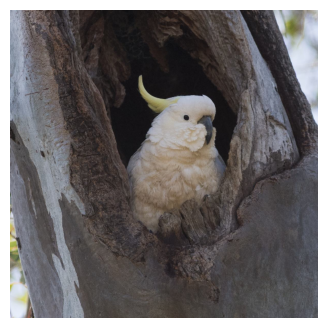

In [11]:
plt.figure(figsize = (4,4))
plt.imshow(Y_raw)
plt.axis('off')
plt.show()
plt.close()

In [12]:
X_raw = np.array(np.meshgrid(np.arange(Y_raw.shape[0]), np.arange(Y_raw.shape[1]))).reshape(2,-1).T

In [13]:
ratio = 0.25
train_idx = random.choice(key, np.arange(X_raw.shape[0]), shape = (int(X_raw.shape[0] * ratio), ), replace = False)
X_train = X_raw[train_idx]
mu_X, sigma_X = X_train.mean(0), X_train.std(0)
X_train = (X_train - mu_X) / sigma_X
X_test = (X_raw - mu_X) / sigma_X
Y_train = Y_raw.reshape(-1,3)[train_idx]
mu_Y, sigma_Y = Y_train.mean(0), Y_train.std(0)
Y_train = (Y_train - mu_Y) / sigma_Y
print(f'Ratio of pixel used: {ratio}')

Ratio of pixel used: 0.25


In [14]:
layers = [X_train.shape[1], *[256 for _ in range(16)], Y_train.shape[1]]
activation = np.tanh
fit_model = MLPRegression(layers, activation = activation)

In [15]:
batch_size = 1024
data_sampler = sampler(X_train, Y_train, batch_size)

In [16]:
init_model = initNet(layers[:-1], activation = activation)
#init_model.plot_degree(init_model.scale_params, fit_model.net_params[:-1], X, word = False)

In [22]:
lr = 5e-3
init_fn, update_fn, get_params = optimizers.adam(lr)
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)
lam = 1e-5
@jit
def step(i, state, X):
    key = random.PRNGKey(i)
    g = grad(init_model.regulated_logSineLoss)(get_params(state), init_model.net_init(key), X, lam = lam)
    return update_fn(i, g, state)
print(f'Important: confirm lam {lam} before running!!!!!!!!!!!!!!!')

Important: confirm lam 1e-06 before running!!!!!!!!!!!!!!!


In [23]:
opt_state = init_fn(init_model.scale_params)
init_nIter = 20000
pbar = trange(init_nIter)
scale_stor = []
bias_stor = []

for i in pbar:
    mini_batch = data_sampler.sample(random.PRNGKey(i))[0]
    opt_state = step(i, opt_state, mini_batch)
    
    if i % 100 == 0:
        params = get_params(opt_state)
        pbar.set_postfix({'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), mini_batch)})
        scale_stor.append([w for (w, b) in params])
        bias_stor.append([b for (w, b) in params])
        

scale_stor = np.array(scale_stor)
bias_stor = np.array(bias_stor)
        


100%|██████████| 20000/20000 [01:09<00:00, 288.80it/s, Log sine loss=0.0044944966]


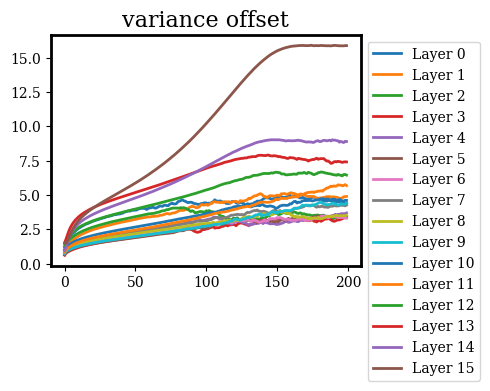

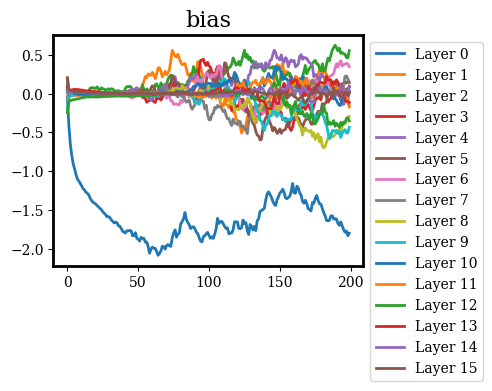

In [24]:
plt.figure(figsize = (4,3))
for i, s in enumerate(scale_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
plt.legend(bbox_to_anchor = (1., 1.))
plt.title('variance offset')
plt.show()
plt.close()

plt.figure(figsize = (4,3))
for i, s in enumerate(bias_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
plt.legend(bbox_to_anchor = (1., 1.))
plt.title('bias')
plt.show()
plt.close()

In [20]:
scale_params = params

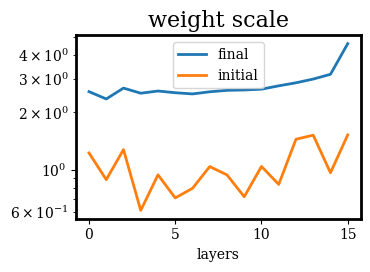

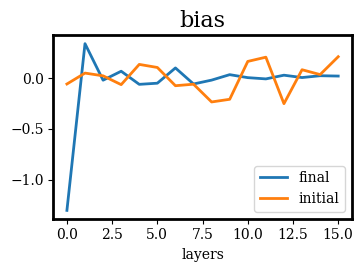

In [21]:
plt.figure(figsize = (4,3))

plt.plot([w_init for w_init, b_init in scale_params], label = 'final')
plt.plot([w_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.yscale('log')
plt.xlabel('layers')
plt.legend()
plt.title('weight scale')
plt.tight_layout()

plt.show()
plt.close()

plt.figure(figsize = (4,3))

plt.plot([b_init for w_init, b_init in scale_params], label = 'final')
plt.plot([b_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.xlabel('layers')
plt.legend()
plt.title('bias')
plt.tight_layout()

plt.show()
plt.close()

In [21]:
fit_model.scaled_net_params = parameter_scaling(fit_model.net_params[:-1], scale_params) + [fit_model.net_params[-1]]

In [22]:
key = random.PRNGKey(int(time.time()*100))

In [23]:
# lr = 1e-3
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)

init_fn, update_fn, get_params = optimizers.adam(optimizers.exponential_decay(1e-3, decay_steps = 200, decay_rate = 0.99))

@jit
def step(i, state, batch):
    g = grad(fit_model.loss)(get_params(state), batch)
    return update_fn(i, g, state)

In [24]:
nIter = 400000

In [25]:
pbar = trange(nIter)

opt_state = init_fn(fit_model.scaled_net_params)

scaled_loss_stor = []

for i in pbar:
    mini_batch = data_sampler.sample(random.PRNGKey(i))
    opt_state = step(i, opt_state, mini_batch)
    if i % 1000 == 0:
        params = get_params(opt_state)
        loss_val = fit_model.loss(params, mini_batch)
        
        scaled_loss_stor.append(loss_val)
        pbar.set_postfix({'loss': loss_val})
        
scaled_loss_stor = np.array(scaled_loss_stor)

scaled_opt_params = params



100%|██████████| 400000/400000 [17:41<00:00, 376.74it/s, loss=0.009263707] 


In [26]:

pbar = trange(nIter)

opt_state = init_fn(fit_model.net_params)

loss_stor = []

for i in pbar:
    mini_batch = data_sampler.sample(random.PRNGKey(i))
    opt_state = step(i, opt_state, mini_batch)
    if i % 1000 == 0:
        params = get_params(opt_state)
        loss_val = fit_model.loss(params, mini_batch)
        
        loss_stor.append(loss_val)
        pbar.set_postfix({'loss': loss_val})
        
loss_stor = np.array(loss_stor)

normal_opt_params = params



100%|██████████| 400000/400000 [17:05<00:00, 389.91it/s, loss=0.025961727]


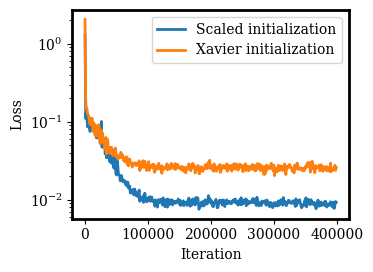

In [27]:
plt.figure(figsize = (4,3))
plt.plot(1000 * np.arange(scaled_loss_stor.shape[0]), scaled_loss_stor, label = 'Scaled initialization')
plt.plot(1000 * np.arange(loss_stor.shape[0]), loss_stor, label = 'Xavier initialization')
plt.yscale('log')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()
plt.close()

In [28]:
print(fit_model.l2_error(normal_opt_params, (X_train, Y_train)))
print(fit_model.l2_error(scaled_opt_params, (X_train, Y_train)))

0.16026014
0.0954852


In [29]:
normal_pred_img = (fit_model.net_apply(normal_opt_params, X_test) * sigma_Y + mu_Y).reshape(Y_raw.shape)
scaled_pred_img = (fit_model.net_apply(scaled_opt_params, X_test) * sigma_Y + mu_Y).reshape(Y_raw.shape)

In [30]:
normal_pred_img.min()

DeviceArray(7.123558, dtype=float32)

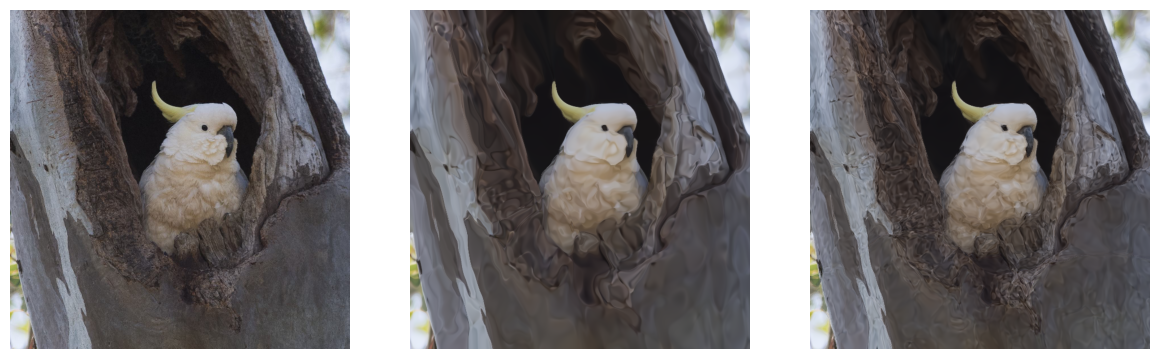

In [44]:
plt.figure(figsize = (12, 8))
plt.subplot(1,3,1)
plt.imshow(Y_raw/255)
plt.axis('off')
plt.tight_layout()
plt.subplot(1,3,2)
plt.imshow(np.clip(normal_pred_img/255, a_min = 0, a_max = 1))
plt.axis('off')
plt.tight_layout()
plt.subplot(1,3,3)
plt.imshow(np.clip(scaled_pred_img/255, a_min = 0, a_max = 1))
plt.tight_layout()
plt.axis('off')

plt.savefig(path + 'result.pdf', dpi = 300)

plt.show()
plt.close()

In [41]:
mask = np.ones(Y_raw.shape).reshape(-1,3)
mask = index_update(mask, train_idx, 1).reshape(Y_raw.shape)

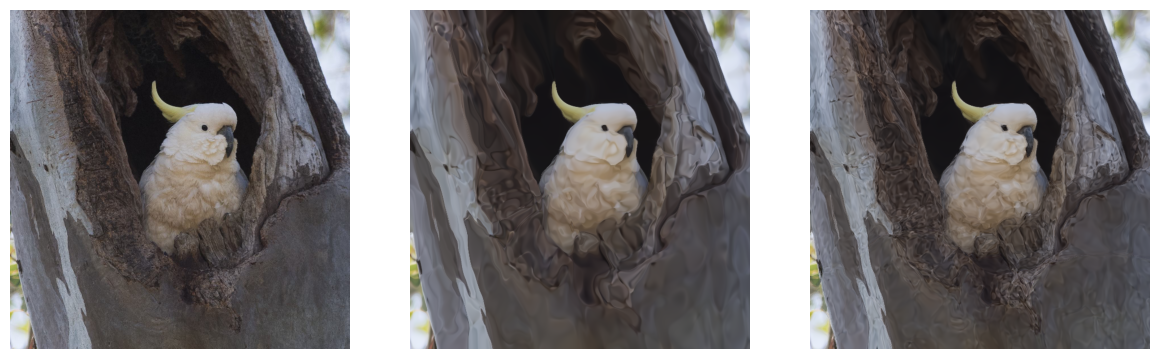

In [43]:
plt.figure(figsize = (12, 8))
plt.subplot(1,3,1)
plt.imshow(mask * Y_raw/255)
plt.axis('off')
plt.tight_layout()
plt.subplot(1,3,2)
plt.imshow(np.clip(normal_pred_img/255, a_min = 0, a_max = 1))
plt.axis('off')
plt.tight_layout()
plt.subplot(1,3,3)
plt.imshow(np.clip(scaled_pred_img/255, a_min = 0, a_max = 1))
plt.tight_layout()
plt.axis('off')

plt.savefig(path + 'train_result.pdf', dpi = 300)

plt.show()
plt.close()